In [1]:
import numpy as np
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit



ro=8.
#paper on MC used R0=8.5 kpc, using ro=8. as of now.
vo=220.

Populating the interactive namespace from numpy and matplotlib


In [ ]:
hdulist=fits.open('molecular_clouds/J_ApJ_834_57_table1.dat.gz.fits')
print (hdulist[1].columns)
aa=hdulist[1].data

#To setup the orbits of the MCs, take (l,b,d) --> galactocentric rectangular coordinates

[R,vR,vT(,z,vz,phi)]

In [ ]:
l=aa['GLON']
b=aa['GLAT']
#Near or far distance flag (0=near; 1=far) 
flag=aa['INF']
Dnear=aa['Dnear']
Dfar=aa['Dfar']
znear=aa['znear']
zfar=aa['zfar']
R_sph_gal=aa['Rgal']
Rnear=aa['Rnear']
Rfar=aa['Rfar']
Mnear=aa['Mnear']
Mfar=aa['Mfar']

#The radius of the GMCs follow $R \sim 295\rm{pc}\left(\frac{M}{10^7 \rm{M}_{\odot}}\right)^{0.45}$ which is very similar to the subhalo mass profile, but $R$ includes the entire mass of the GMC. We will model the GMCs as Plummer spheres whose 90% mass is within $3\times$ its scale radius, and use the $r_{s}(M)=100\rm{pc}\left(\frac{M}{10^7 \rm{M}_{\odot}}\right)^{0.5}$

In [ ]:
def lbd_to_galcencyl(l,b,d,degree=True):
    xyz=bovy_coords.lbd_to_XYZ(l,b,d,degree=degree)
    Rphiz=bovy_coords.XYZ_to_galcencyl(xyz[:,0],xyz[:,1],xyz[:,2],Xsun=1.,Zsun=0.)
    
    return (Rphiz[:,0],Rphiz[:,1],Rphiz[:,2])

D_all=np.empty(len(l))
zfile=np.empty(len(l))
rs_all=np.empty(len(l))
M_all=np.empty(len(l))


for ii in range(len(l)):
    if flag[ii] == 0 :
        D_all[ii]=Dnear[ii]
        zfile[ii]=znear[ii]
        rs_all[ii]=Rnear[ii]*0.001  #convert to kpc
        M_all[ii]=Mnear[ii]
        
        
    else :
        D_all[ii]=Dfar[ii]
        zfile[ii]=zfar[ii]
        rs_all[ii]=Rfar[ii]*0.001 #convert to kpc
        M_all[ii]=Mfar[ii]
        

def rs(M):
    return 0.1*(M/10**7.)**0.5

#for ii in range(len(M_all)):
#    rs_all[ii]=rs(M_all[ii])


R_all,phi_all,z_all= lbd_to_galcencyl(l,b,D_all*(8.5/8.))
R_all1,phi_all1,z_all1= lbd_to_galcencyl(l,b,D_all)

R_all/=ro
z_all/=ro

R_all1/=ro
z_all1/=ro



In [ ]:
xyz=bovy_coords.lbd_to_XYZ(l,b,D_all*(8.5/8.),degree=True)
xyz1=bovy_coords.lbd_to_XYZ(l,b,D_all,degree=True)

plt.figure(figsize=(10,10))
plt.scatter(xyz[:,0],xyz[:,1],s=1)
plt.scatter(xyz1[:,0],xyz1[:,1],s=1,c='r')
plt.xlim(-15.,15.)
plt.ylim(-15.,15.)
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.show()

In [ ]:
print (max(np.abs(z_all*ro-zfile)))  #computed z and z from catalog match pretty well

print (max(rs_all))
print (max(M_all),min(M_all))

In [ ]:
#Pick only MCs which are more massive than Mmin
Mmin=10**5.

M=[]
rs=[]
z=[]
R=[]
phi=[]

for ii in range(len(l)):
    if M_all[ii] >= Mmin :
        M.append(M_all[ii])
        rs.append(rs_all[ii])
        z.append(z_all[ii])
        phi.append(phi_all[ii])
        R.append(R_all[ii])
        
M=np.array(M)
rs=np.array(rs)
z=np.array(z)
R=np.array(R)
phi=np.array(phi)

print (len(M), len(M_all))


In [ ]:
#Rs vs M


def rs_Hern(M):
    return 1.62*(M/10**8.)**0.5

def rs_Plum(M):
    return 1.05*(M/10**8.)**0.5

mm=np.linspace(10.,10**8.)

plt.figure()
plt.scatter(M_all,rs_all)
plt.plot(mm,rs_Hern(mm),label='Hernquist',c='k',lw=2)
plt.plot(mm,rs_Plum(mm),label='Plummer',c='r',lw=2)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-5,10)
plt.xlim(0.001,10**8.)
plt.xlabel(r'M ($\rm{M}_{\odot}$)')
plt.ylabel(r'$r_{s}$ (kpc)')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#assign velocities, tangential velocity = vcirc, vR=vz=0
vT=np.empty(len(M))

for ii in range(len(M)):
    vT[ii]=vcirc(MWPotential2014,R[ii])

#print (vT)

vR=np.zeros(len(M))
vz=np.zeros(len(M))


In [ ]:
#initialize orbits of the MCs and integrate them back 5 Gyrs 
#as of now use MWPotential2014, because it's axisymmetric and static
#integrate back and extract (x,v) at different timpact through interpolation

t_age= np.linspace(0.,5.,1001)/bovy_conversion.time_in_Gyr(vo,ro)
orbits= []

#M=M[0:10]


N=len(M)

for ii in range(N):
    
    #print ([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]])
    orbits.append(Orbit([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]]).flip()) # flip flips the velocities for backwards integration
    
    orbits[ii].integrate(t_age,MWPotential2014)
    

In [ ]:
print (M)
orbits[9].plot(d1='x',d2='y',ro=ro,vo=vo)

orbits[9].plot(ro=ro,vo=vo)

In [ ]:
orbits[1].plot('k.',d1='ra',d2='dec',ro=ro,vo=vo)

In [ ]:
import pal5_util
sdf_smooth= pal5_util.setup_pal5model()

In [14]:
#load the saved pickle file for converting apars to obs coords
with open('pkl_files/pal5pepper_4096sampling_MW2014_33.pkl','rb') as savefile:
            #sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')
            
#load the saved pickle file for converting apars to obs coords
with open('pkl_files/pal5pepper_4096sampling_pot19_peri5.54_33.pkl','rb') as savefile:
            #sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper_1= pickle.load(savefile,encoding='latin1')

In [15]:
import MWPotential2014Likelihood
import pal5_util
import pal5_util_MWfit
_REFR0, _REFV0= MWPotential2014Likelihood._REFR0, MWPotential2014Likelihood._REFV0


sdf_smooth= pal5_util.setup_pal5model()

##########setup Pal5 orbit and potential
ind=1
param_file='rperi_grid_select.dat'
paramf=np.genfromtxt(param_file,delimiter=',')  
pind=paramf[ind][0]
peri=round(paramf[ind][1],2)
print (peri)

flat_c=paramf[ind][2]
vc=paramf[ind][3]
tvo= vc*_REFV0

#indices greater than 14: subtract 1
if pind > 14 :
    pind -=1
    
pind=int(pind)   
potparams_file=np.loadtxt('pot_params.dat',delimiter=',')
potparams=list(potparams_file[pind])
   
pot= MWPotential2014Likelihood.setup_potential(potparams,flat_c,False,False,
                                                       pal5_util_MWfit._REFR0,tvo)


sdf_smooth_1= pal5_util.setup_pal5model(pot=pot)

5.54


In [8]:
timpact=sdf_pepper._timpact*bovy_conversion.time_in_Gyr(vo,ro)

timpact1=sdf_pepper_1._timpact*bovy_conversion.time_in_Gyr(vo,ro)

print (timpact,timpact1)

[2.57871613 2.57993654 2.58115694 2.58237735 2.58359775 2.58481816
 2.58603856 2.58725897 2.58847938 2.58969978 2.59092019 2.59214059
 2.593361   2.5945814  2.59580181 2.59702221 2.59824262 2.59946302
 2.60068343 2.60190383 2.60312424 2.60434464 2.60556505 2.60678545
 2.60800586 2.60922626 2.61044667 2.61166707 2.61288748 2.61410788
 2.61532829 2.61654869 2.6177691  2.6189895  2.62020991 2.62143031
 2.62265072 2.62387113 2.62509153 2.62631194 2.62753234 2.62875275
 2.62997315 2.63119356 2.63241396 2.63363437 2.63485477 2.63607518
 2.63729558 2.63851599 2.63973639 2.6409568  2.6421772  2.64339761
 2.64461801 2.64583842 2.64705882 2.64827923 2.64949963 2.65072004
 2.65194044 2.65316085 2.65438125 2.65560166] [3.12545765 3.12667806 3.12789846 3.12911887 3.13033927 3.13155968
 3.13278008 3.13400049 3.13522089 3.1364413  3.1376617  3.13888211
 3.14010251 3.14132292 3.14254332 3.14376373 3.14498413 3.14620454
 3.14742495 3.14864535 3.14986576 3.15108616 3.15230657 3.15352697
 3.15474738 3.15

In [16]:
timpact=sdf_pepper._timpact

print (timpact)


print (len(timpact))

pal5= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip()
pal5.integrate(t_age,MWPotential2014)



[72.52531991 72.55964329 72.59396668 72.62829007 72.66261346 72.69693685
 72.73126024 72.76558363 72.79990701 72.8342304  72.86855379 72.90287718
 72.93720057 72.97152396 73.00584734 73.04017073 73.07449412 73.10881751
 73.1431409  73.17746429 73.21178768 73.24611106 73.28043445 73.31475784
 73.34908123 73.38340462 73.41772801 73.4520514  73.48637478 73.52069817
 73.55502156 73.58934495 73.62366834 73.65799173 73.69231511 73.7266385
 73.76096189 73.79528528 73.82960867 73.86393206 73.89825545 73.93257883
 73.96690222 74.00122561 74.035549   74.06987239 74.10419578 74.13851917
 74.17284255 74.20716594 74.24148933 74.27581272 74.31013611 74.3444595
 74.37878288 74.41310627 74.44742966 74.48175305 74.51607644 74.55039983
 74.58472322 74.6190466  74.65336999 74.68769338]
64


NameError: name 't_age' is not defined

In [ ]:
t_age= np.linspace(0.,5.,1001)/bovy_conversion.time_in_Gyr(vo,ro)
pal5= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip()
pal5.integrate(t_age,MWPotential2014)
pal5.rperi()

# Plot Pal5 orbit, trailing arm and the progenitor at different timpacts

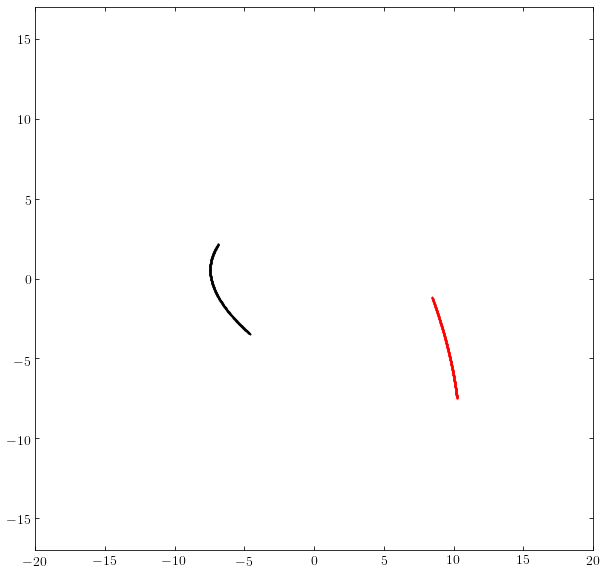

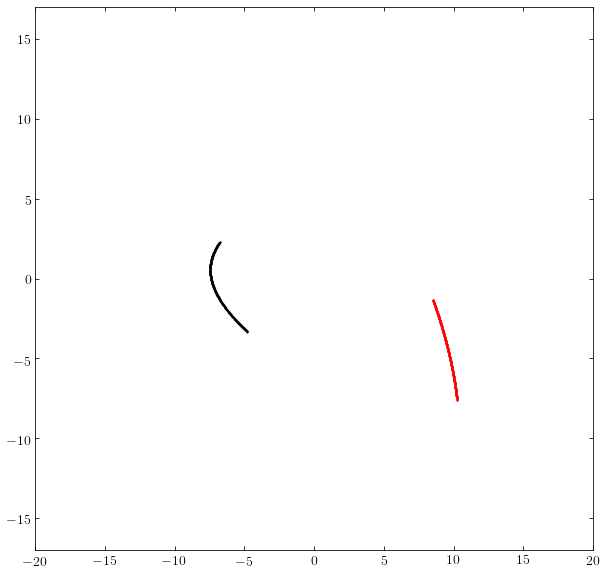

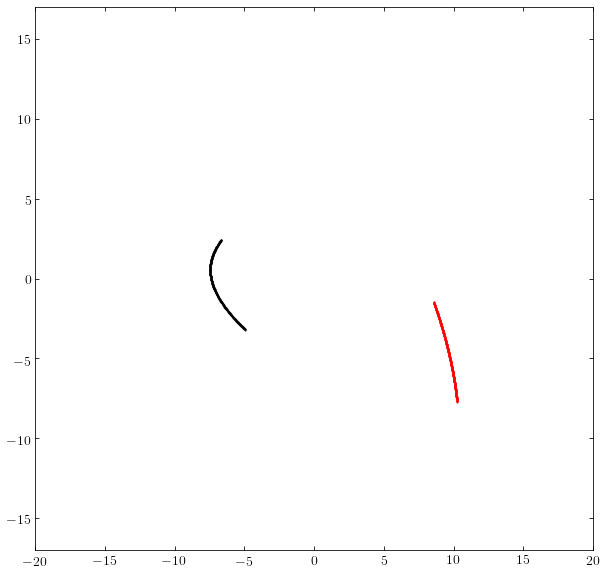

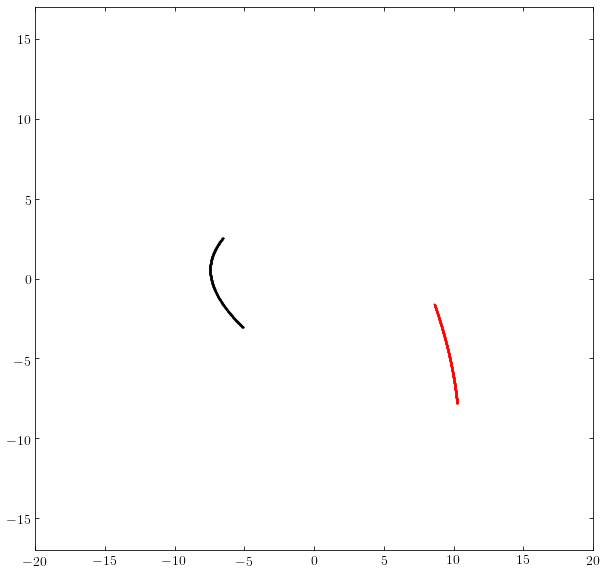

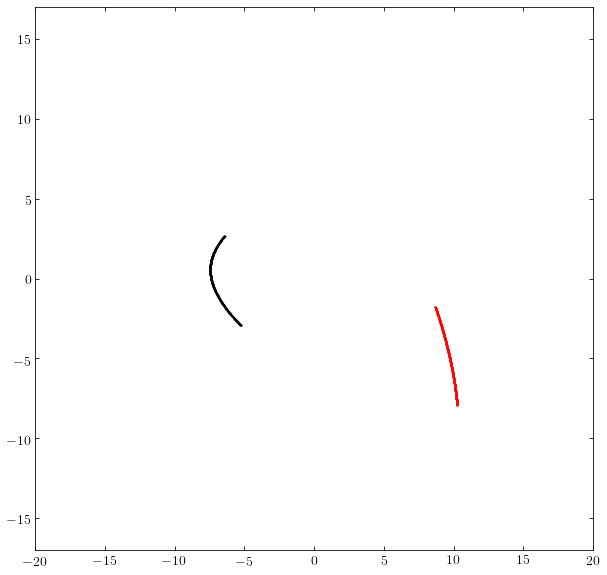

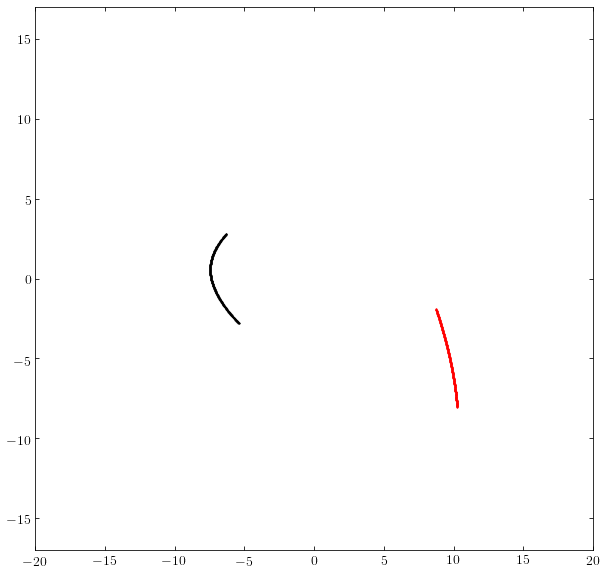

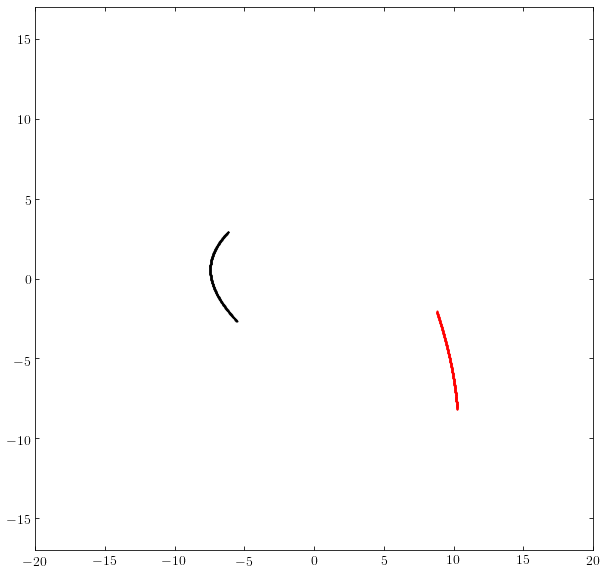

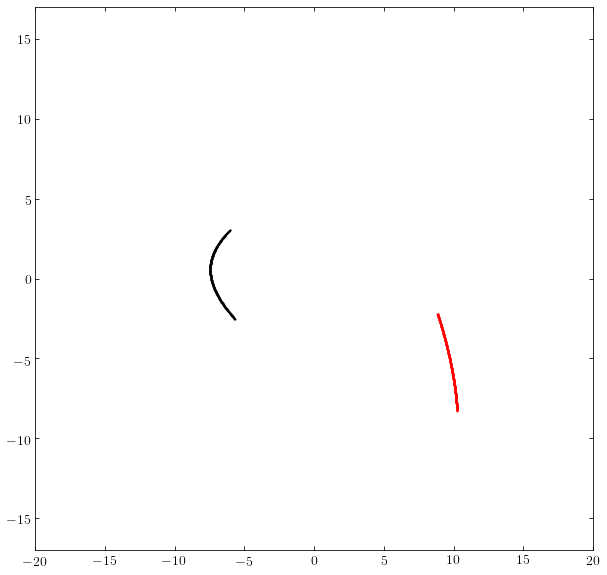

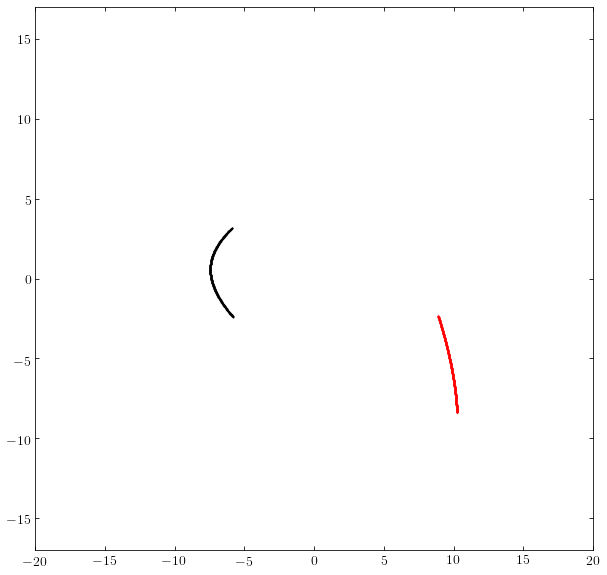

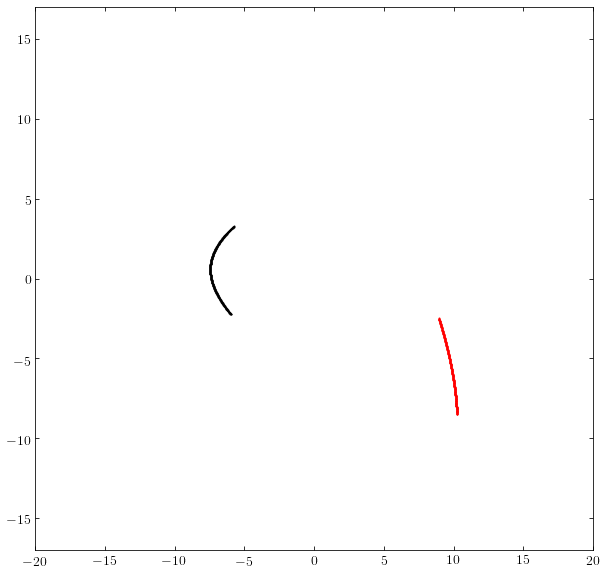

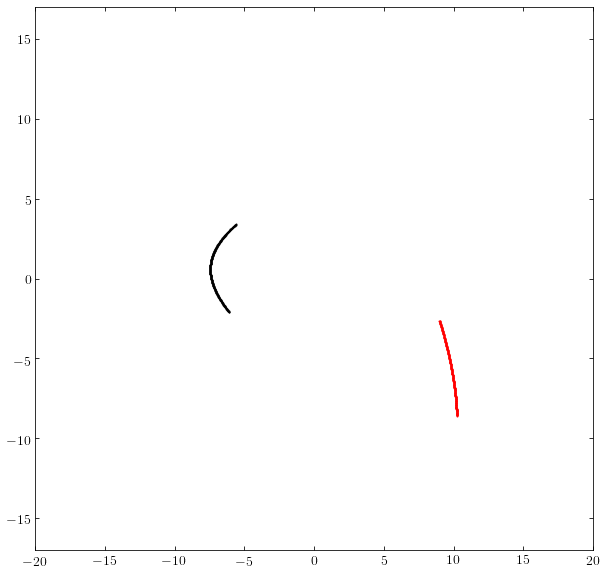

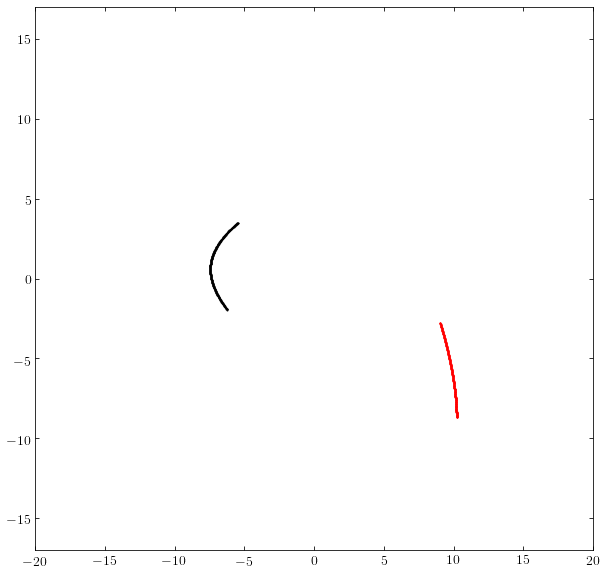

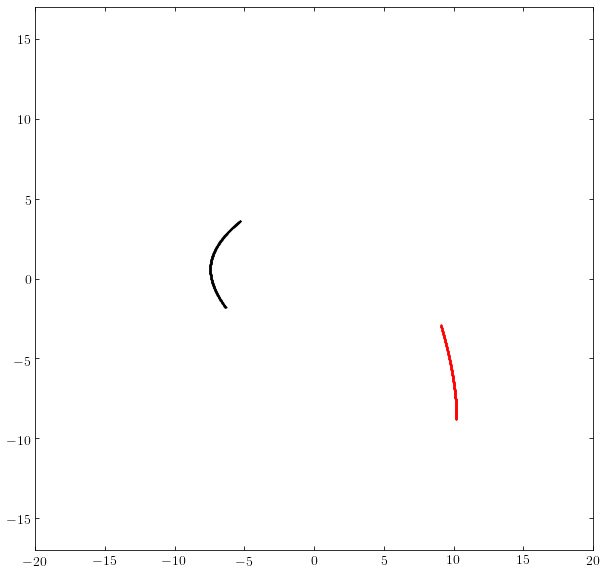

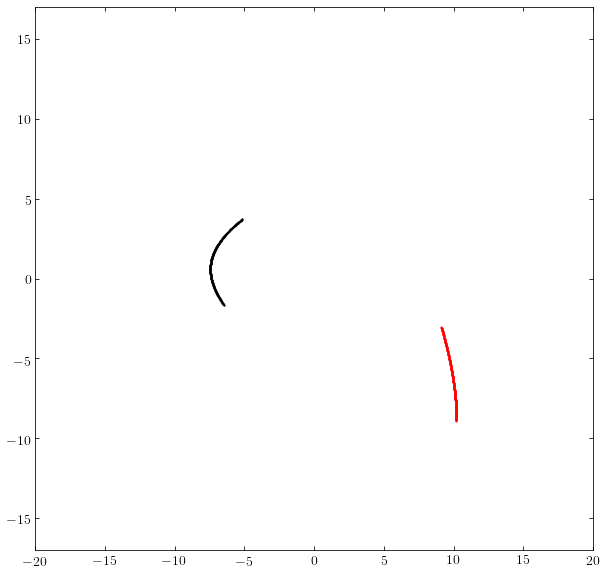

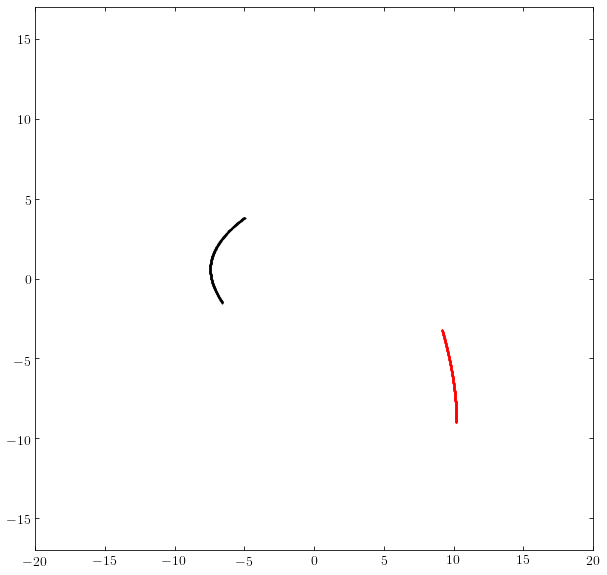

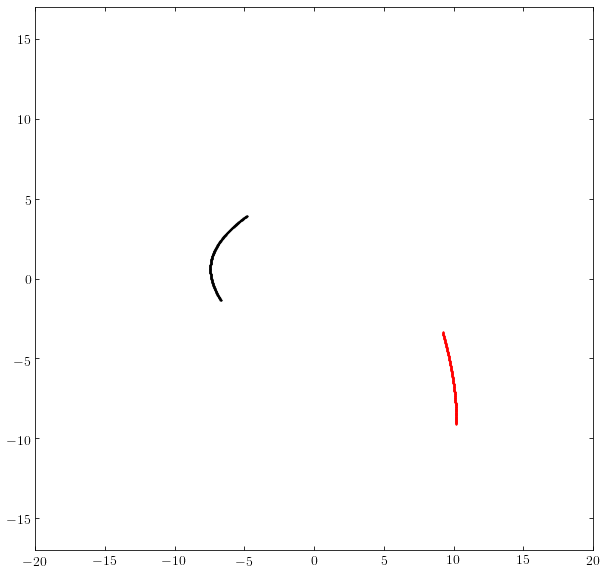

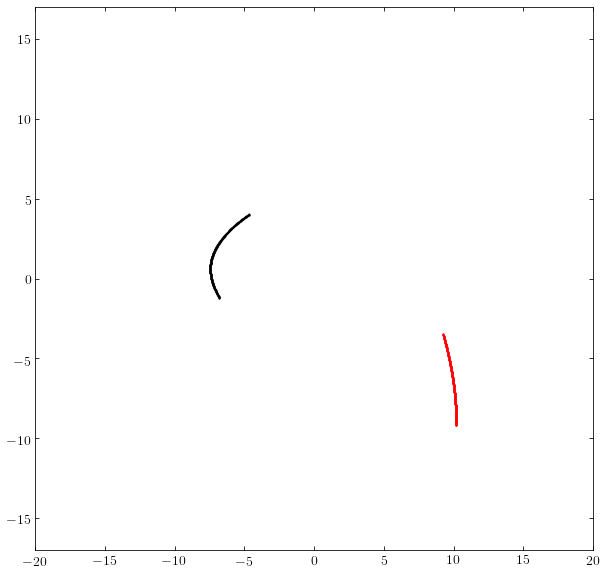

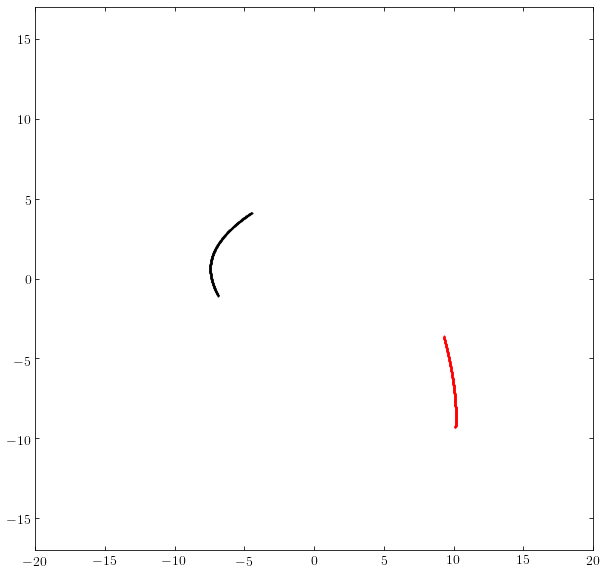

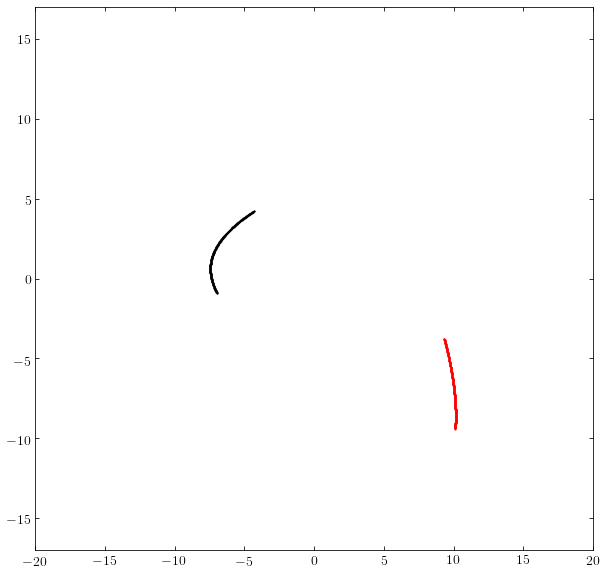

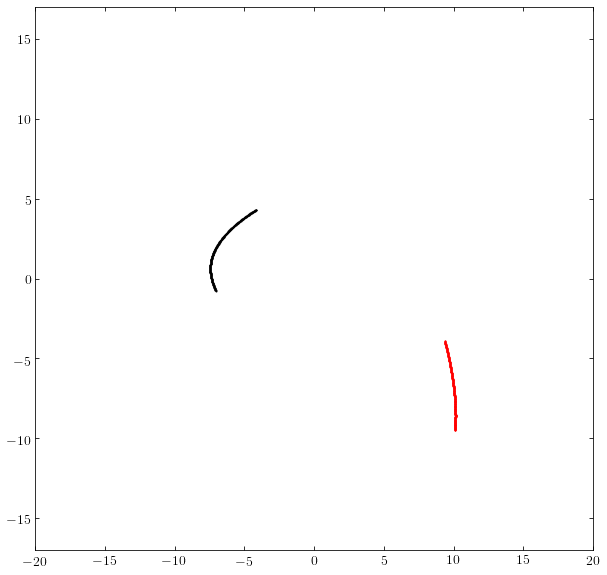

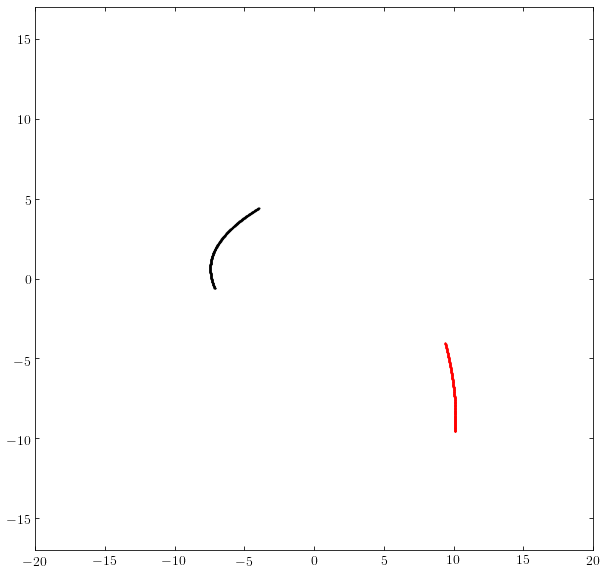

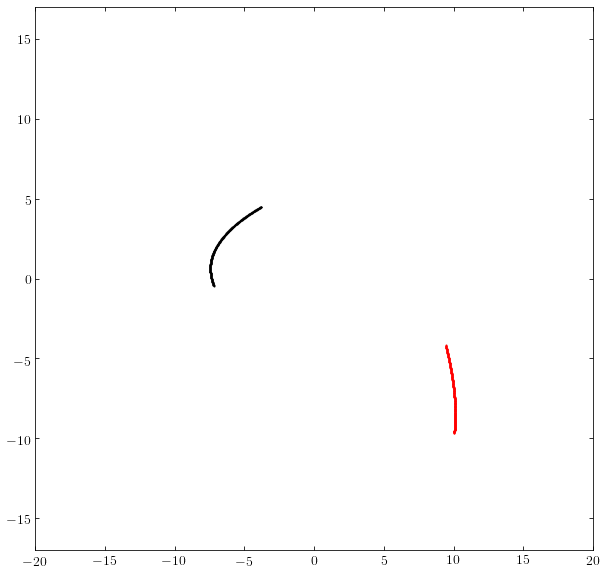

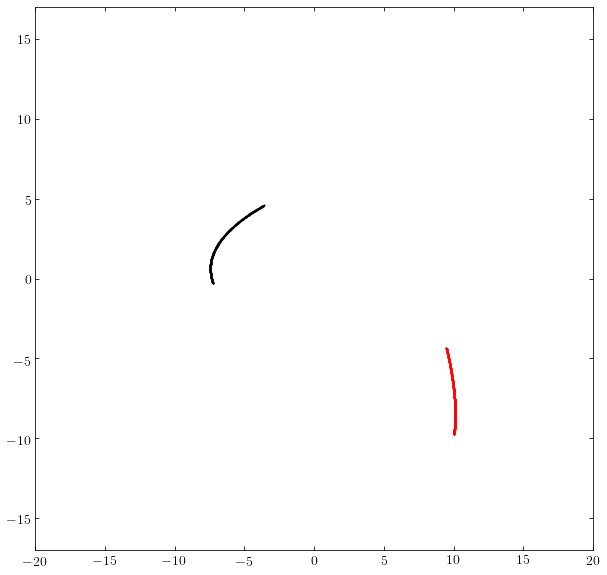

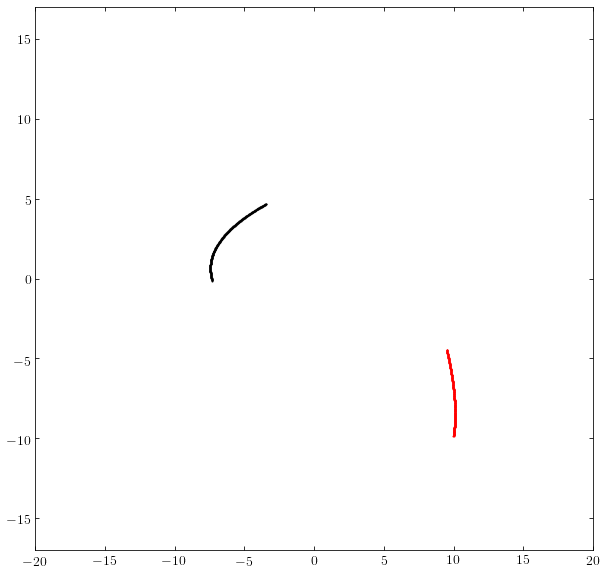

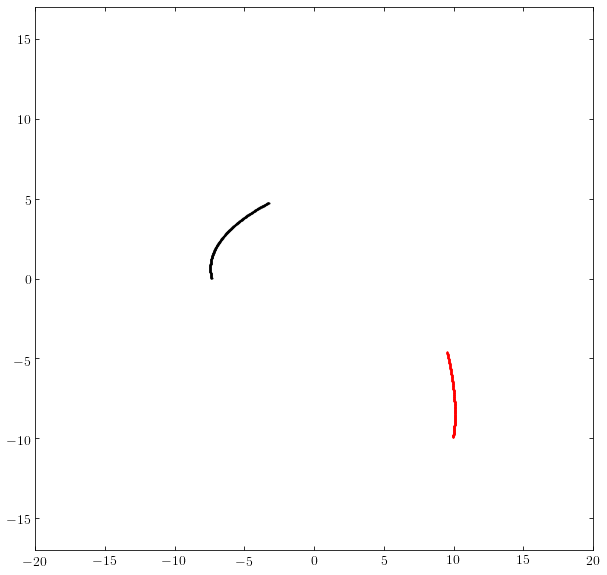

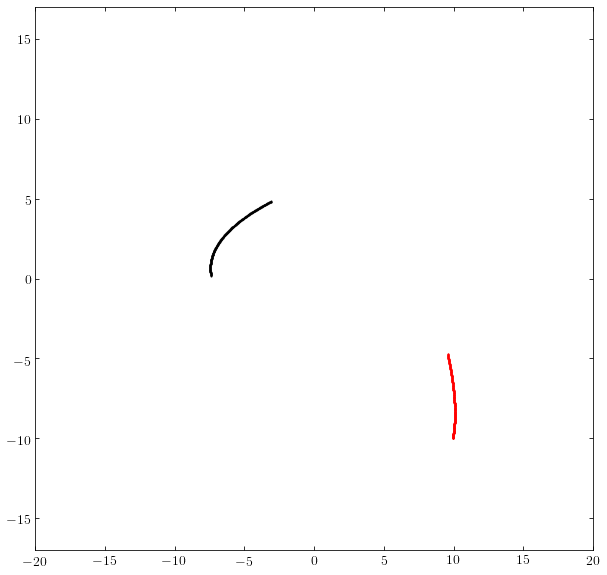

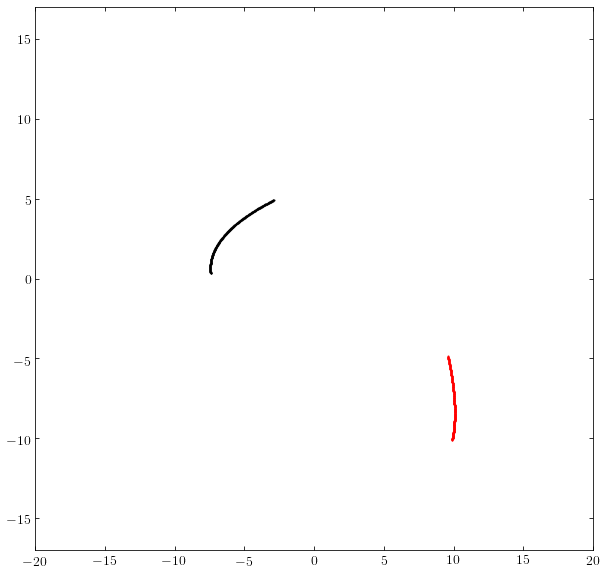

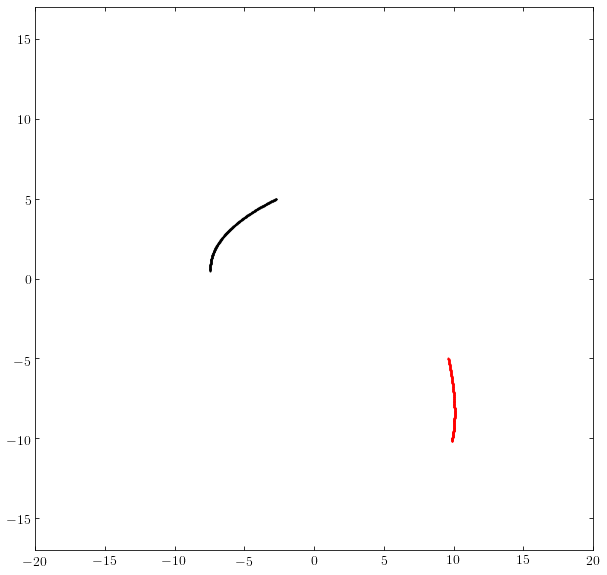

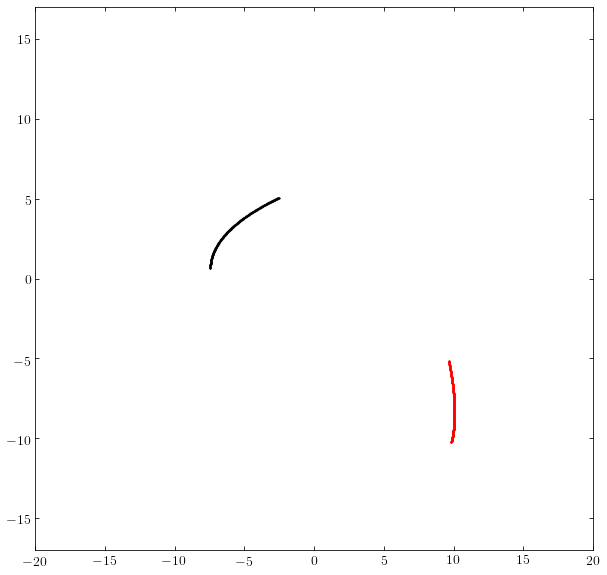

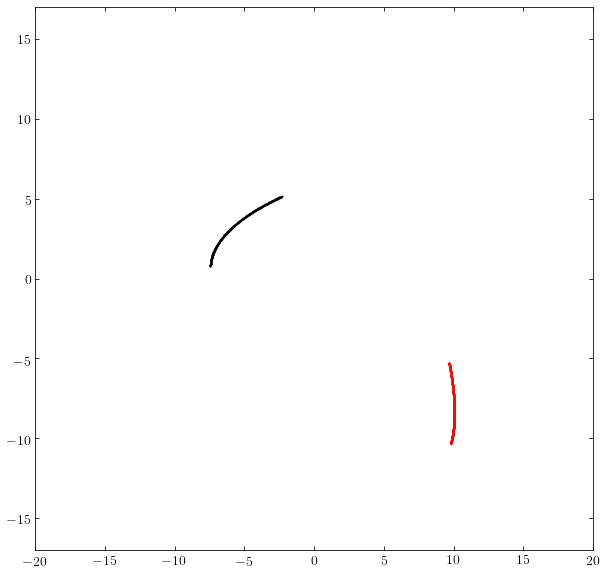

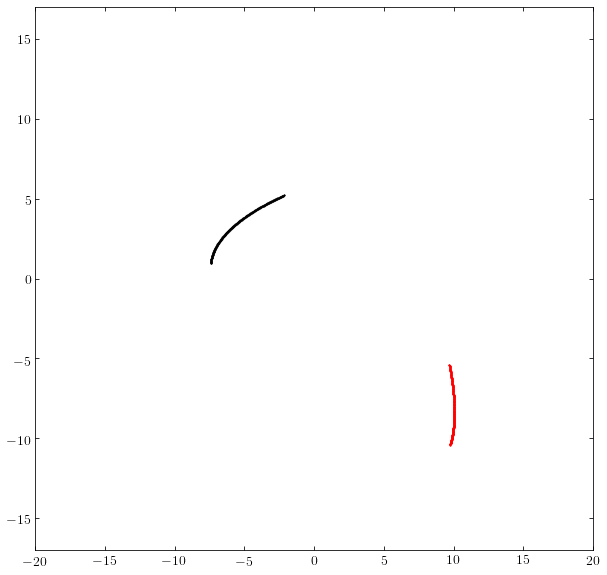

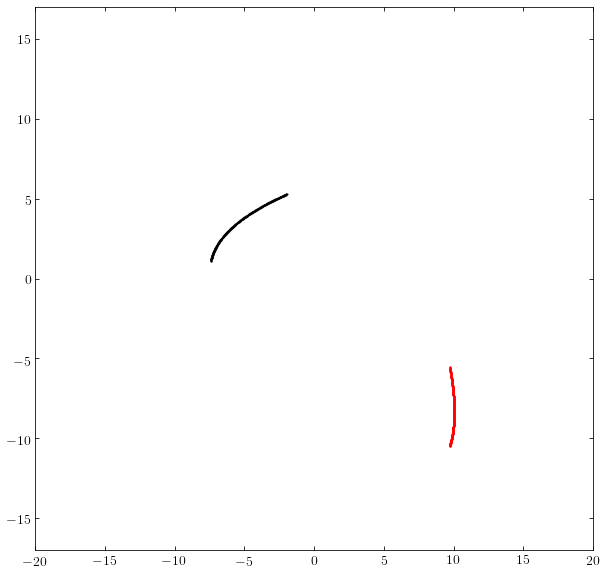

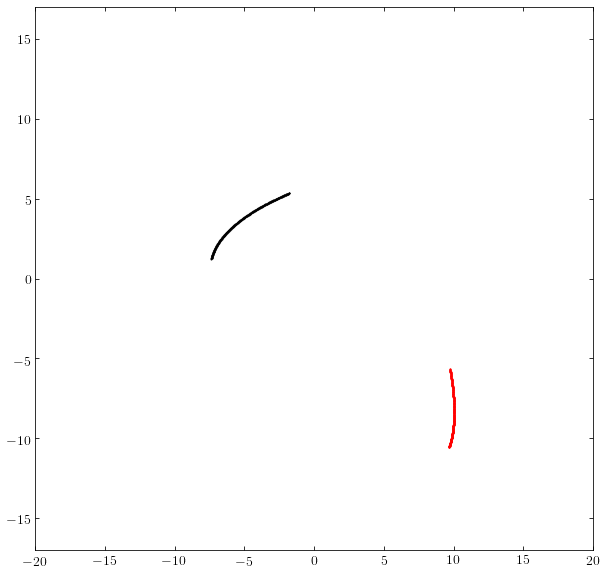

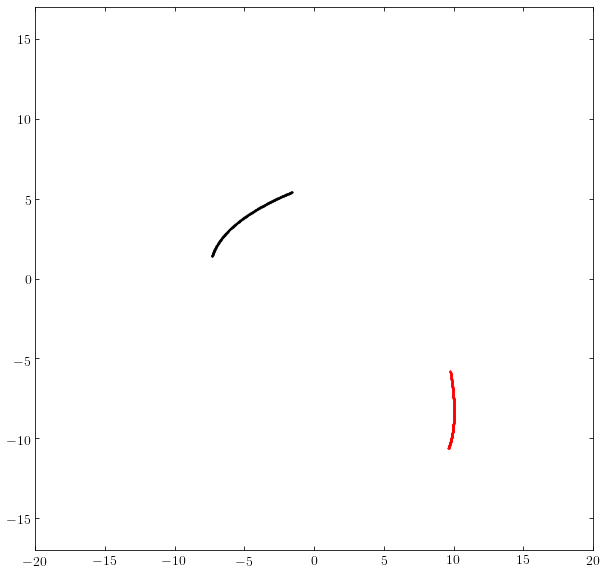

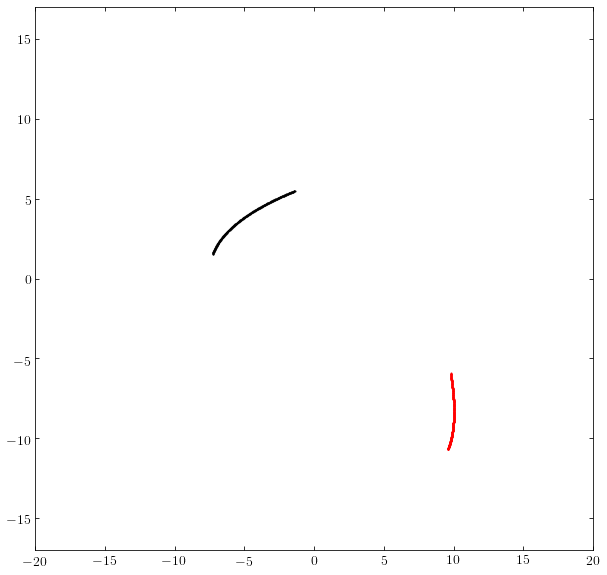

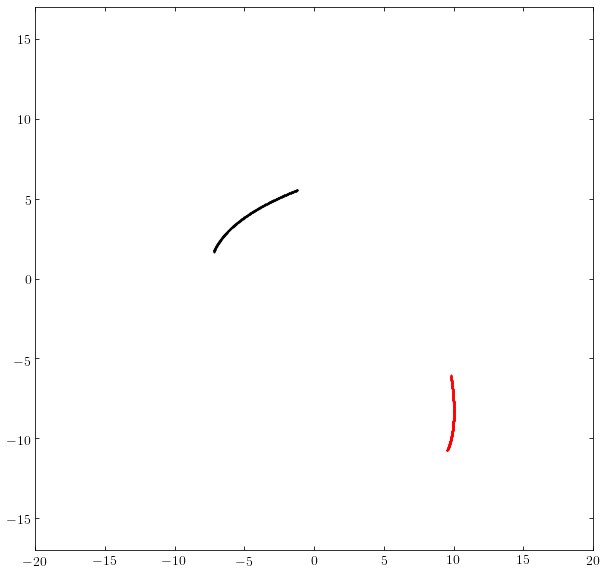

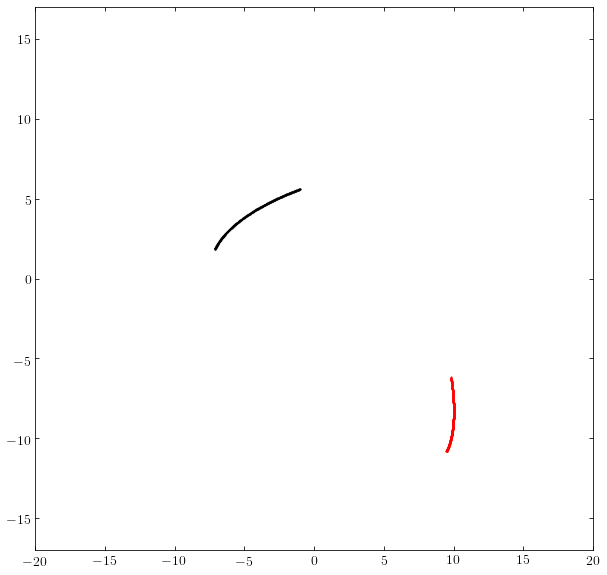

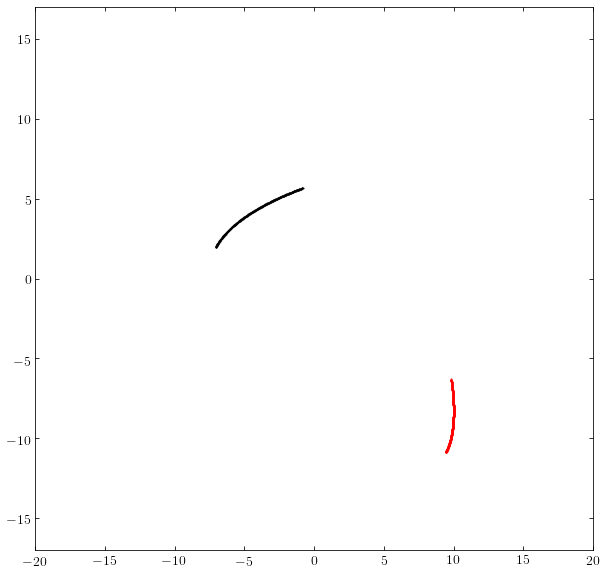

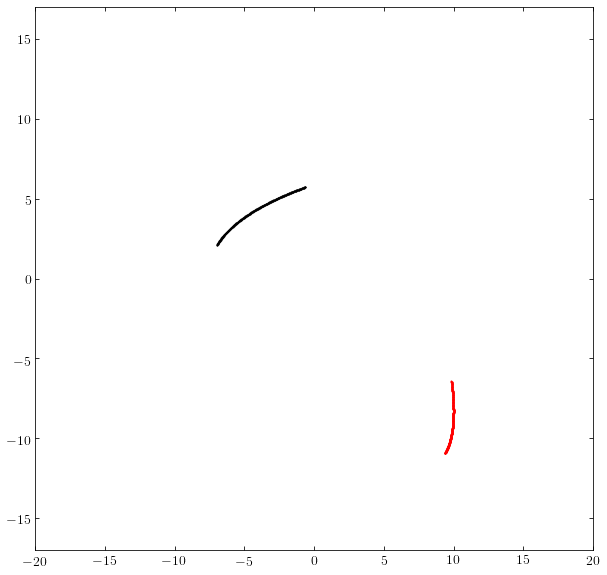

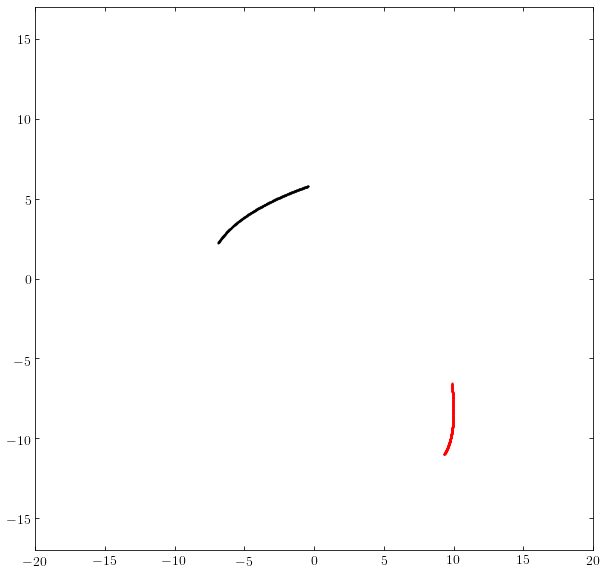

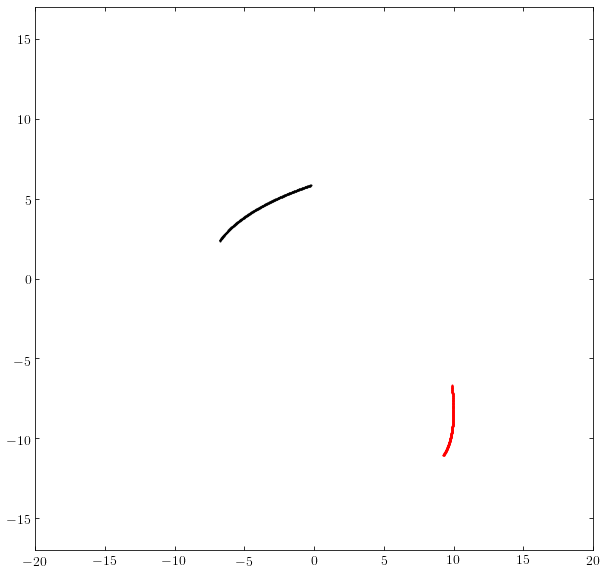

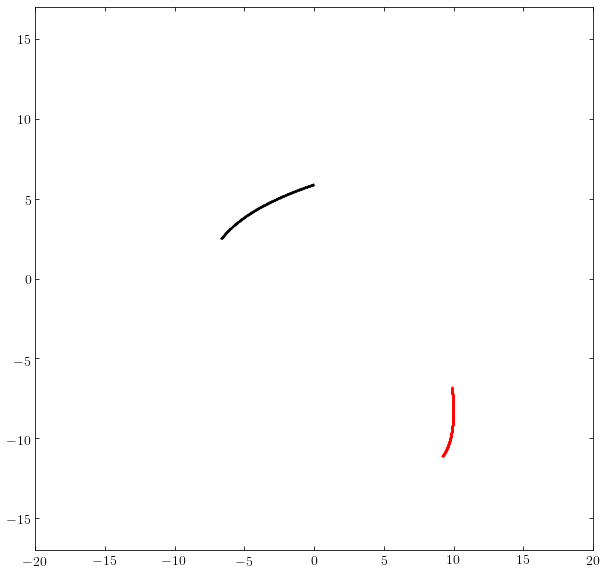

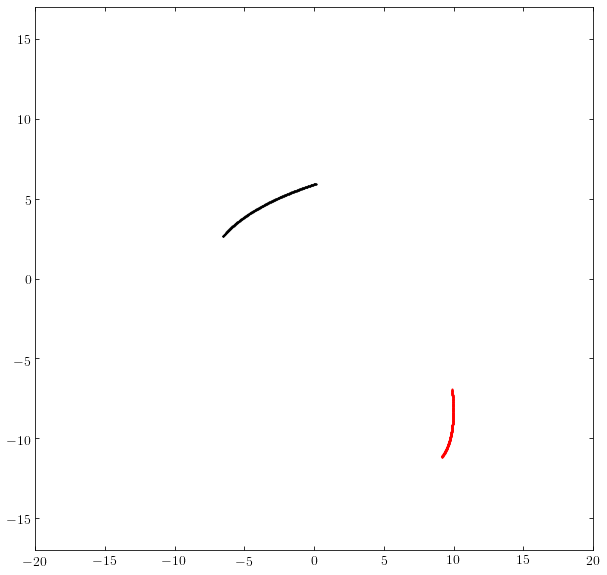

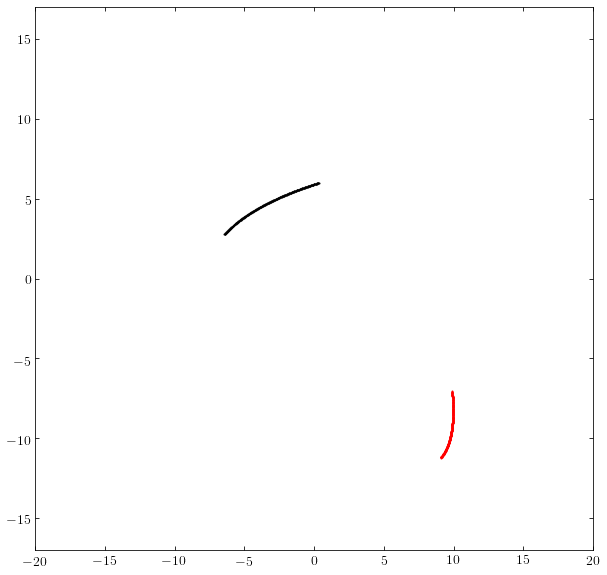

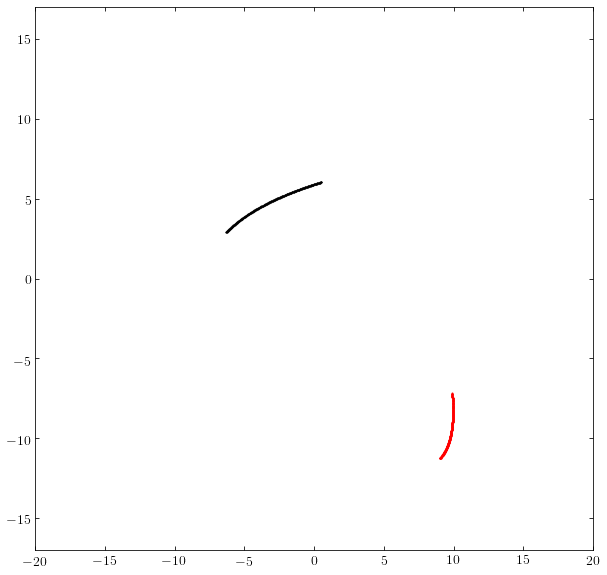

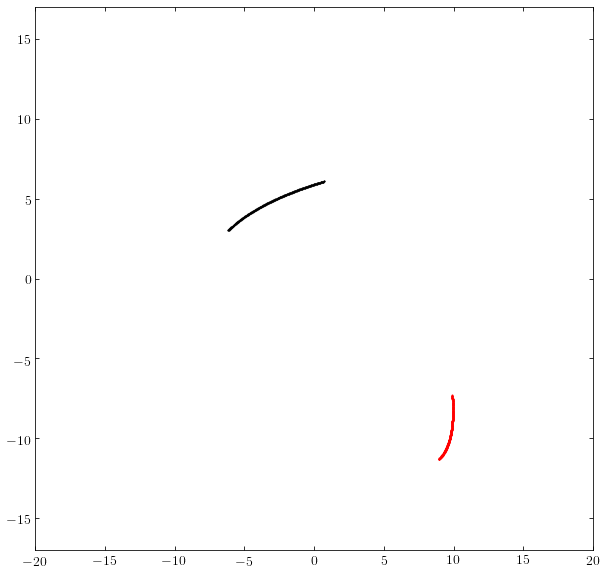

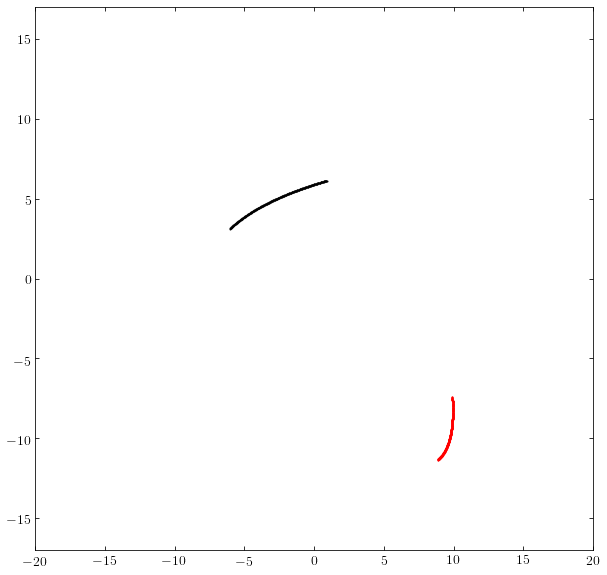

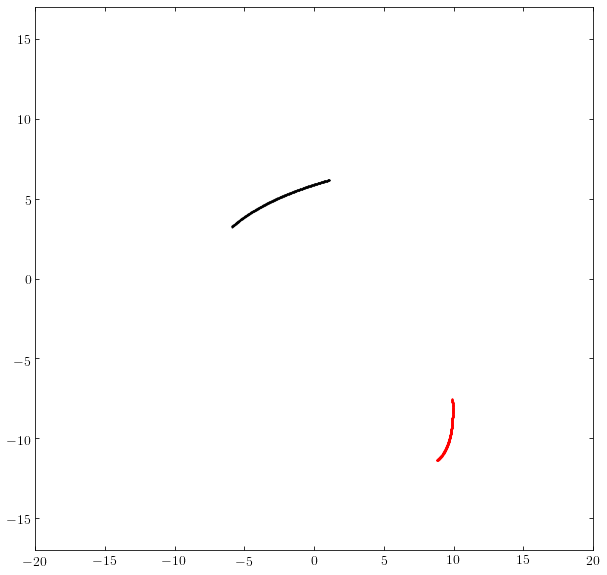

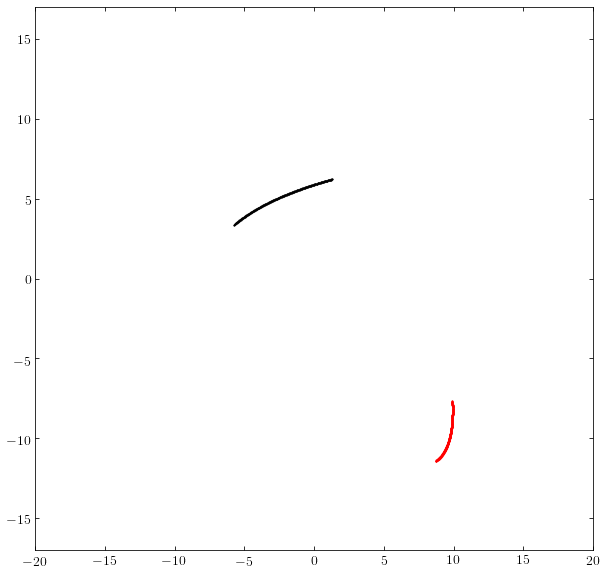

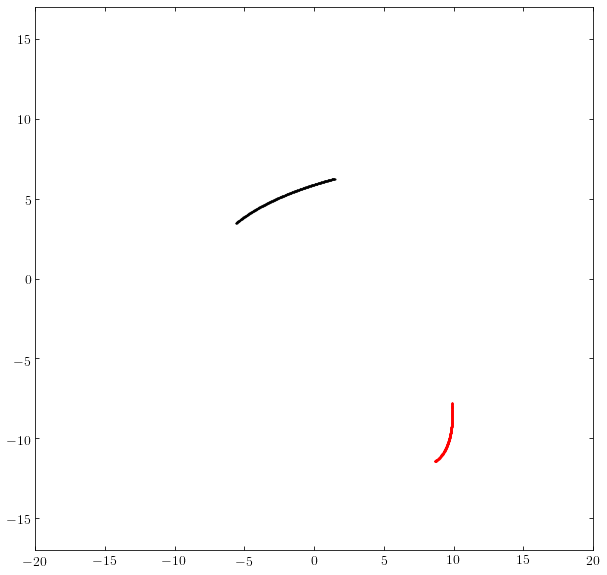

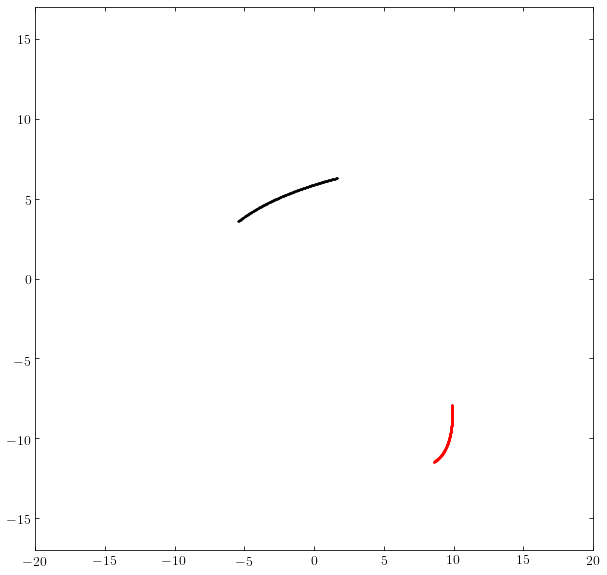

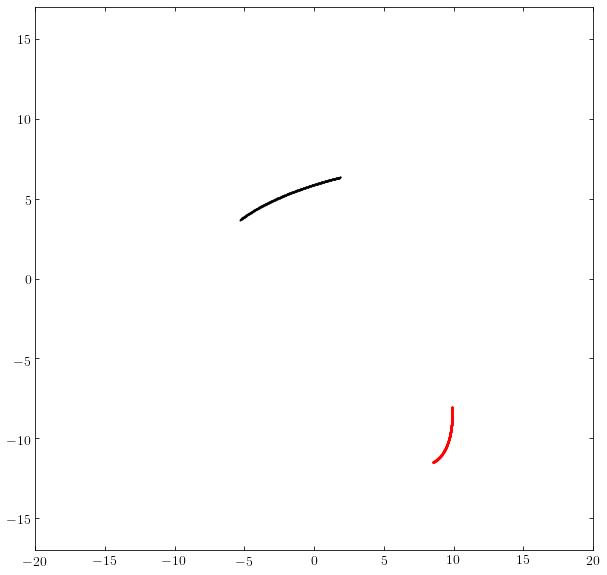

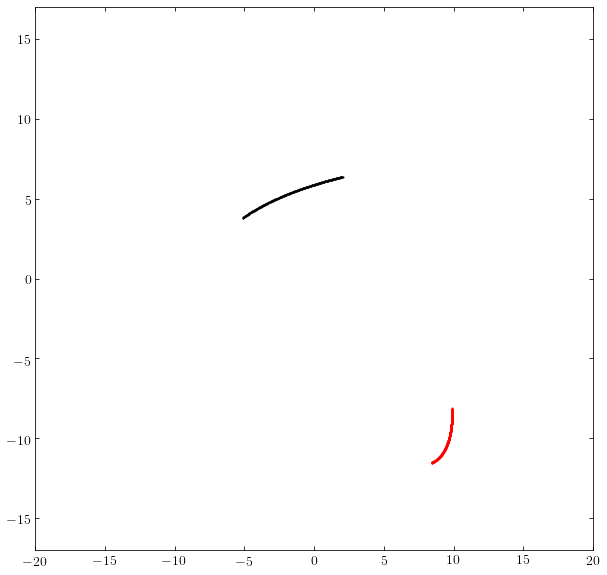

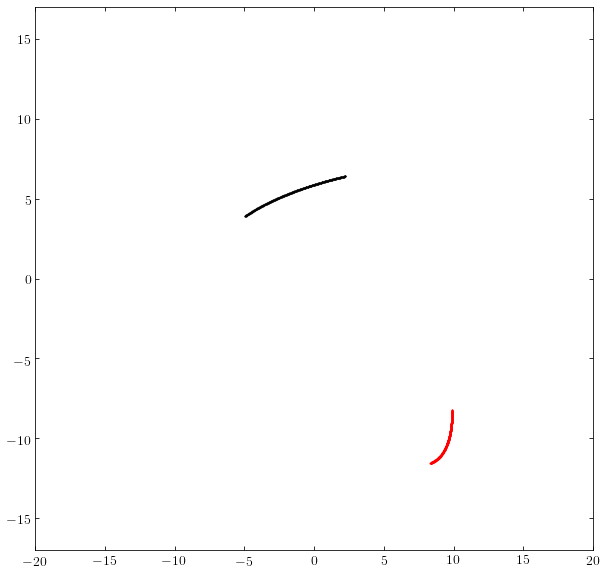

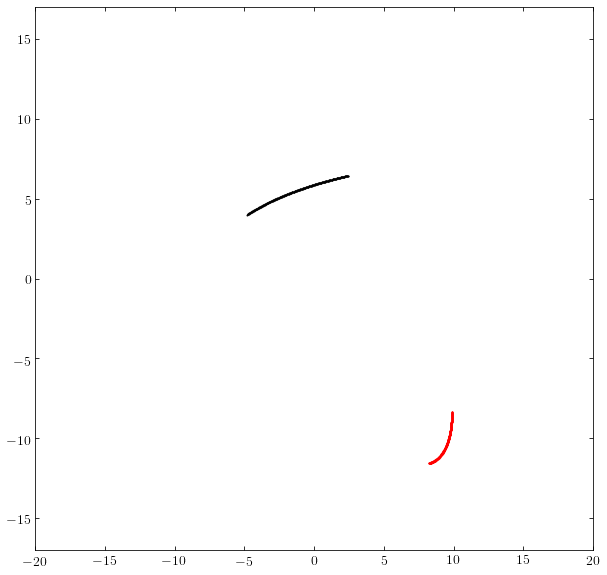

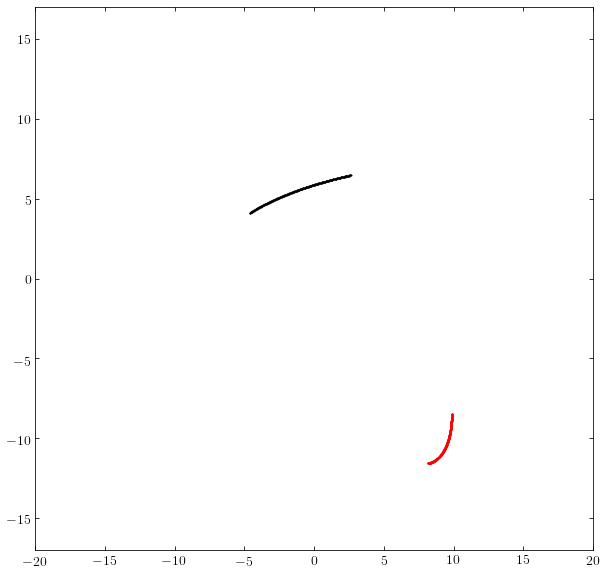

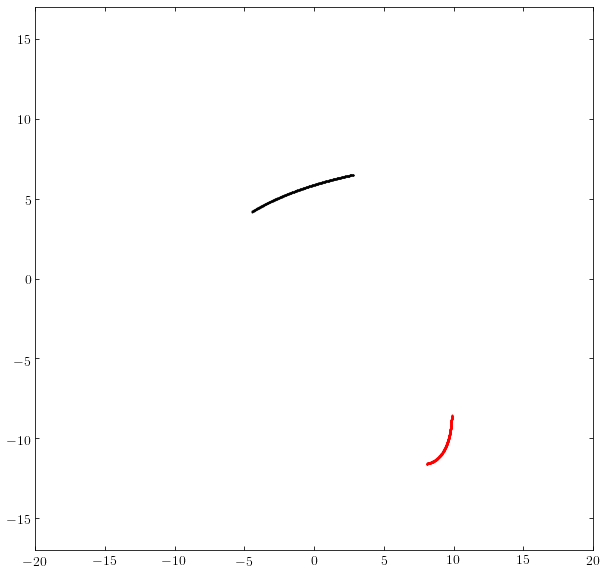

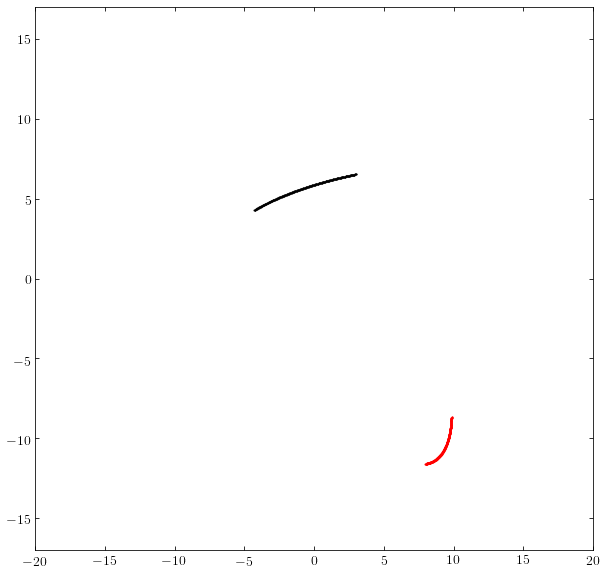

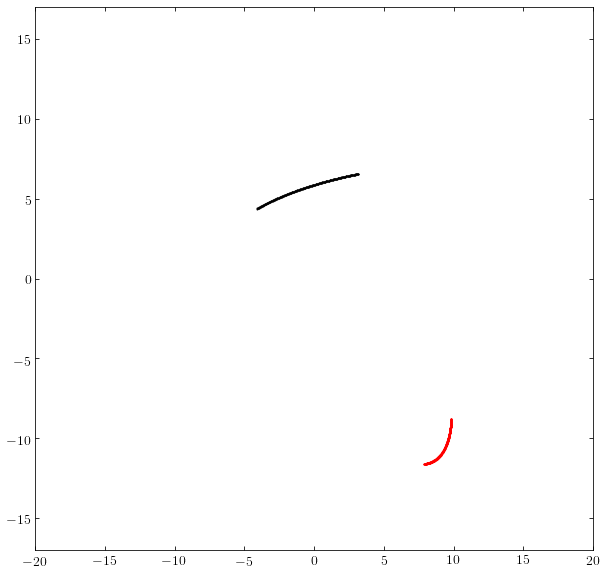

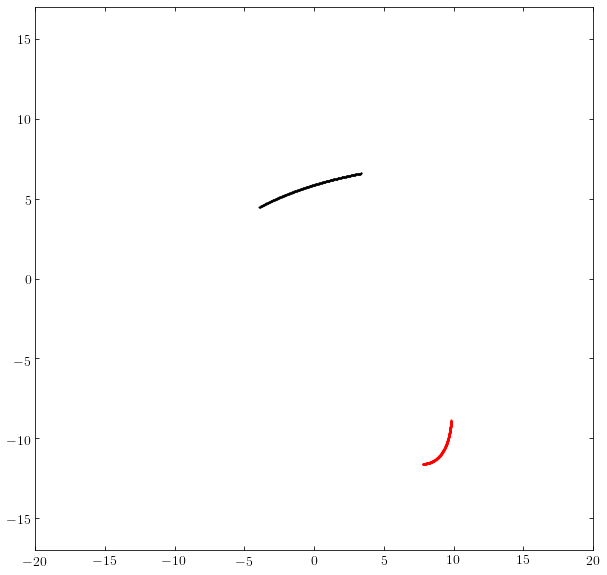

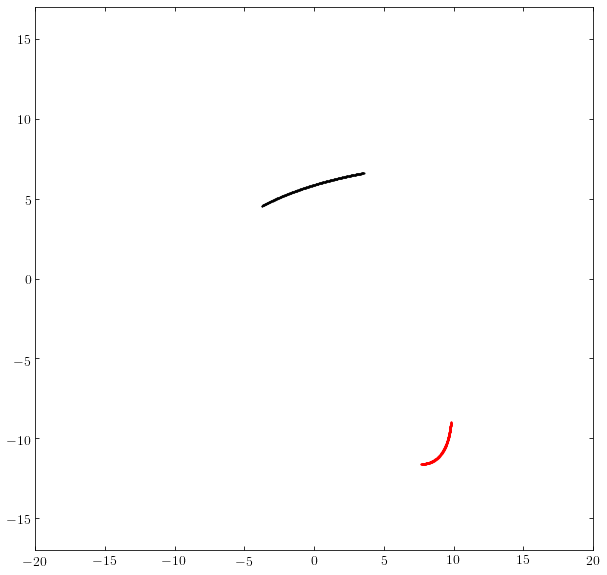

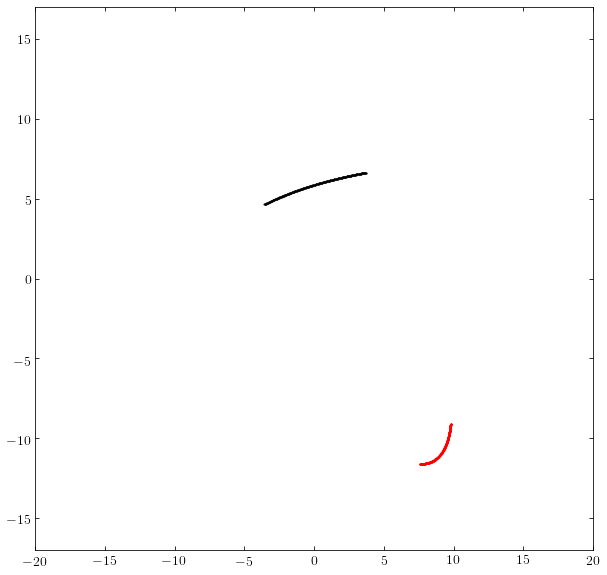

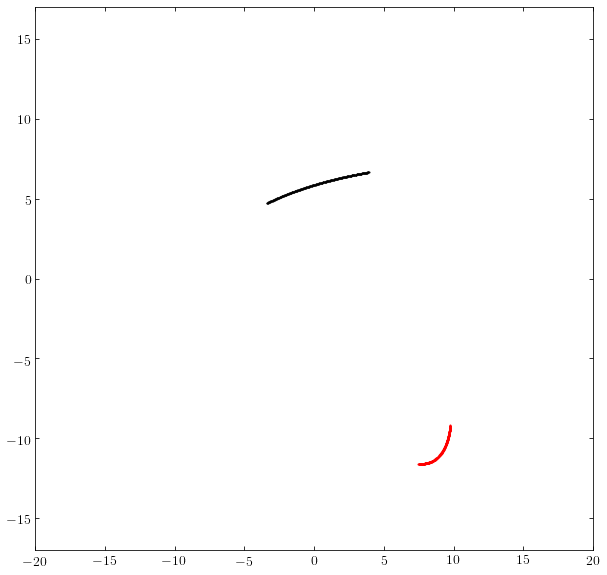

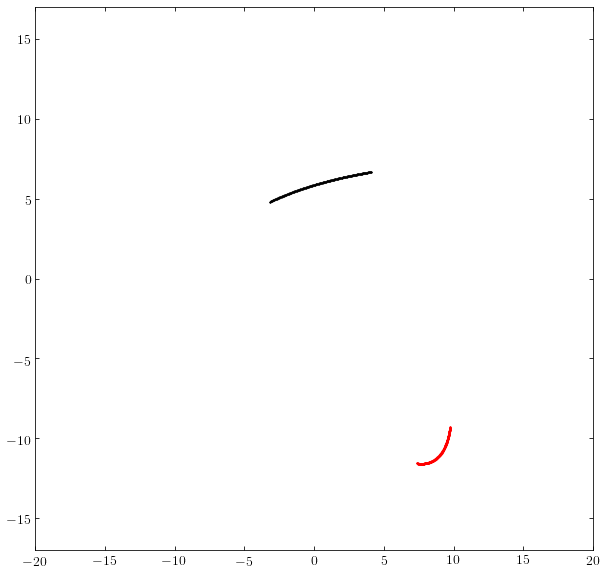

In [18]:
for kk in range(len(timpact)):
    
    x=[]
    y=[]
    z=[]
    vx=[]
    vy=[]
    vz=[]
    x1=[]
    y1=[]
    z1=[]
    
    a= sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedObsTrackXY
    apar_all=sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedThetasTrack
    
    a1= sdf_pepper_1._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedObsTrackXY
    apar_all1=sdf_pepper_1._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedThetasTrack
    
    #lbd=bovy_coords.XYZ_to_lbd(a[:,0],a[:,1],a[:,2],degree=True)
    #radec_all=bovy_coords.lb_to_radec(lbd[:,0],lbd[:,1],degree=True) 
    #print (max(radec_all[:,0]))
    #radec_all[:,0][radec_all[:,0]>=180.]-=360.
         
    bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
    figsize(10,10)
    #pal5.plot(d1='x',d2='y')
    #scatter(np.array(a[:,0])*ro,np.array(a[:,1])*ro,c='r',s=1)
    #scatter(pal5.x(timpact[kk]),pal5.y(timpact[kk]),s=100,c='g')
    
    #at each timpact compute apar_max
    apar_max=sdf_smooth.length(tdisrupt=sdf_pepper._tdisrupt-timpact[kk])*sdf_pepper._length_factor
    apar_max1=sdf_smooth_1.length(tdisrupt=sdf_pepper_1._tdisrupt-timpact[kk])*sdf_pepper_1._length_factor
    
    #considering the stream until apar_max, store xyzvxvyvz 
    for ii in range(len(apar_all)):
        if apar_all[ii] <= apar_max : 
            x.append(a[:,0][ii])
            y.append(a[:,1][ii])
            z.append(a[:,2][ii])
        
   
    for ii in range(len(apar_all1)):
        if apar_all1[ii] <= apar_max1 : 
            x1.append(a1[:,0][ii])
            y1.append(a1[:,1][ii])
            z1.append(a1[:,2][ii])
    
    #lbd1=bovy_coords.XYZ_to_lbd(np.array(x),np.array(y),np.array(z),degree=True)
    #radec=bovy_coords.lb_to_radec(lbd1[:,0],lbd1[:,1],degree=True) 
    #print (radec[:,0])
    #radec[:,0][radec[:,0]>=180.]-=360.
    
    #print (radec[:,0])
    
    
    
    plt.scatter(np.array(x)*ro,np.array(y)*ro,c='k',s=1)
    plt.scatter(np.array(x1)*ro,np.array(y1)*ro,c='r',s=1)
    plt.xlim(-20.,20.)
    plt.ylim(-17.,17.)
    plt.show()
    
    
    #x.append(a[:,0])
    #y.append(a[:,1])
    #z.append(a[:,2])
    
    
    #apar=apar_all[apar_all < apar_max]
    #print len(apar)
    
    #print (len(a[:,0]))

In [ ]:
def compute_min_separation(x_mc,y_mc,z_mc,apar,x_stream,y_stream,z_stream):
    '''
    given (x,y,z) of each molecular cloud, compute the minimum separation from the stream chunks
    
    input: x_mc,y_mc,z_mc of the MCs,
    x_stream,y_stream,z_stream as arrays of the stream chunks
    apar of the stream chunks, in order to output the apar at which the minimum separation from the 
    MC occured
    '''
    
    diffx=x_stream - x_mc
    diffy=y_stream - y_mc
    diffz=z_stream - z_mc
    
    diffxyz=np.c_[diffx,diffy,diffz]
    
    norm = numpy.linalg.norm(diffxyz,axis=1)
    
    #print (diffx)
    
    #print (norm)
    
    #print (len(x_stream), len(norm))
    
    min_ind=numpy.argmin(norm)
    
    min_sep= norm[min_ind]
    
    apar_min=apar[min_ind]
    
    return (min_sep,apar_min)
    
    

In [4]:
print (sdf_pepper_1._sigMeanSign)


1.0


In [ ]:
#timpact_short=timpact[0:6]

#for each MC store min sep and apar of closest approach at each timpact
min_sep_matrix=np.empty([len(orbits),len(timpact)])
apar_matrix=np.empty([len(orbits),len(timpact)])


for kk in range(len(timpact)):
    
    apar=[]
    x=[]
    y=[]
    z=[]
    vx=[]
    vy=[]
    vz=[]
    
    a= sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedObsTrackXY
    apar_all=sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedThetasTrack
      
            
    #at each timpact compute apar_max
    apar_max=sdf_smooth.length(tdisrupt=sdf_pepper._tdisrupt-timpact[kk])*sdf_pepper._length_factor
    
    #considering the stream until apar_max, store xyzvxvyvz 
    for ii in range(len(apar_all)):
        if apar_all[ii] <= apar_max :
            apar.append(apar_all[ii])
            x.append(a[:,0][ii])
            y.append(a[:,1][ii])
            z.append(a[:,2][ii])
            vx.append(a[:,3][ii])
            vy.append(a[:,4][ii])
            vz.append(a[:,5][ii])
            
    x_stream=np.array(x)
    y_stream=np.array(y)
    z_stream=np.array(z)
    vx_stream=np.array(vx)
    vy_stream=np.array(vy)
    vz_stream=np.array(vz)
    apar=np.array(apar)
    
      
    #compute min_sep of each MC
    for jj in range(len(orbits)) :
        x_mc=orbits[jj].x(timpact[kk])
        y_mc=orbits[jj].y(timpact[kk])
        z_mc=orbits[jj].z(timpact[kk])
        
        min_sep,apar_min=compute_min_separation(x_mc,y_mc,z_mc,apar,x_stream,y_stream,z_stream)
        
        min_sep_matrix[jj,kk]=min_sep
        apar_matrix[jj,kk]=apar_min
        
        #print (min_sep,apar_min)


In [ ]:
#for each MC plot min separation at all timpact

ind=1090

aa=min_sep_matrix[ind]

print (5.*rs[ind]/ro,aa[aa<5.*rs[ind]/ro]) #print min_sep everytime it closer than 5r_s



plt.figure(figsize=(12,6))
plt.scatter(timpact,min_sep_matrix[ind])
plt.hlines(5.*rs[ind]/ro,-1.,150.,label=r'$5\times r_{s}$')
plt.xlabel('timpact (galpy units)')
plt.ylabel('min separation')
plt.legend(loc='upper right')
#plt.savefig('min_separation_MC{}.pdf'.format(ind))
plt.show()

In [ ]:
print (np.shape(min_sep_matrix[0]))

In [ ]:
#from the constructed matrices of min_sep and min_apar, compute the min separation for each MC for all timpact
#and the corresponding apar_min, also compute velocity of the MC at that timpact

#impactb=np.empty(len(orbits))
#impact_angle=np.empty(len(orbits))
#vx_mc=np.empty(len(orbits))
#vy_mc=np.empty(len(orbits))
#vz_mc=np.empty(len(orbits))
#timpact_at_min=np.empty(len(orbits))

impactb=[]
impact_angle=[]
vx_mc=[]
vy_mc=[]
vz_mc=[]
timpact_at_min=[]
rs_mc=[]
M_mc=[]


c=0
for ii in range(len(orbits)):
    
    bmax=5.*rs[ii]/ro
    
    if min(min_sep_matrix[ii]) <= bmax :
        c+=1
        
        min_timpact_ind=np.argmin(min_sep_matrix[ii])
        print (ii)
        impactb.append(min_sep_matrix[ii,min_timpact_ind])
        impact_angle.append(sdf_pepper._sigMeanSign*apar_matrix[ii,min_timpact_ind]) # _sigMeanSign = -/+ = trail/lead
        timpact_at_min.append(timpact[min_timpact_ind])
        rs_mc.append(rs[ii]/ro)
        M_mc.append(M[ii]/bovy_conversion.mass_in_msol(vo,ro))
        #flip velocities
        vx_mc.append(-orbits[ii].vx(timpact[min_timpact_ind]))
        vy_mc.append(-orbits[ii].vy(timpact[min_timpact_ind]))
        vz_mc.append(-orbits[ii].vz(timpact[min_timpact_ind]))

#combine vx,vy,vz to v
v_mc=np.c_[vx_mc,vy_mc,vz_mc]
print (c)

In [ ]:
#a) histogram of timpact
#b) histogram of M (and maybe compare to the full histogram of M)
#c) histogram of impactb
#d) histogram of impact angle
#e) timpact vs. impact angle

#plot histogram of min separation vs timpact

dt=timpact[1]-timpact[0]
tbin_edges=[timpact[0] - 0.5*(dt) + i*dt for i in range(len(timpact)+1)] 


plt.figure(figsize=(17,10))
plt.subplot(2,3,1)
plt.title('timpact')
plt.hist(timpact_at_min,bins=tbin_edges)

plt.subplot(2,3,2)
mbins=np.linspace(10**6.,10**7.,25)

plt.title('M')
plt.hist(np.array(M_mc)*bovy_conversion.mass_in_msol(vo,ro),bins=mbins,histtype='step',lw=2,label=r'minsep $<$ 5rs')
plt.hist(M,bins=mbins,histtype='step',lw=2,label=r'$10^{6} - 10^{7} \rm{M}_{\odot}$')
plt.legend(loc='upper right')



plt.subplot(2,3,3)
plt.title('impactb')
plt.hist(impactb,bins=30,histtype='step',lw=2)





plt.subplot(2,3,4)
plt.title('impact angle')
plt.hist(impact_angle,bins=30,histtype='step',lw=2)




plt.subplot(2,3,5)
plt.title('timpact vs impact angle')
plt.scatter(timpact_at_min,impact_angle)
plt.xlabel('timpact')
plt.ylabel('impact angle')

plt.savefig('plots/MC_impact_test_{}timpacts.pdf'.format(len(timpact)))

plt.show()






In [ ]:
import streampepperdf

sdf_pepper.set_impacts(impactb=impactb,subhalovel=v_mc,impact_angle=impact_angle,timpact=timpact_at_min,rs=rs_mc,GM=M_mc)



In [ ]:
#combine densOmega files

for jj in range(21,42):
    
    apar=np.empty(175)
    dens=np.empty(175)
    dens_unp=np.empty(175)
    Omega=np.empty(175)

    #'#apar   dens_unp   dens  omega_unp   omega'

    for ii in range(175):
        dat=np.loadtxt('MC_densOmega/4096_on_128_Plummer_Mmin105_rand_rotate/densOmega_4096_on_128_Plummer_Mmin105_rand_rotate{}_{}.dat'.format(jj,ii))
        apar[ii]=dat[0]
        dens_unp[ii]=dat[1]
        dens[ii]=dat[2]
        Omega[ii]=dat[4]
        
    #write xi dens/dens_smooth out

    ll,tdata= convert_dens_to_obs(apar,dens,dens_unp,Omega,poly_deg=3)

    fo=open('dens_MCMmin105_rand_rotate_impact_Pal5_4096_on_128_Plummer_timpacts_{}.dat'.format(jj),'w')
    fo.write('#xi   dens/dens_smooth' + '\n')

    for ii in range(len(ll)):
        fo.write(str(ll[ii]) + '   ' + str(tdata[ii]) + '\n')

    fo.close()
    

In [ ]:
import pal5_util
from scipy import ndimage, signal, interpolate
import simulate_streampepper

sdf_smooth= pal5_util.setup_pal5model()

In [ ]:
#load the saved pickle file for converting apars to obs coords, any sdf_pepper does the job
with open('pkl_files/pal5pepper_128sampling_Plummer_MW2014.pkl','rb') as savefile:
            #sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')


def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    outll= numpy.arange(0.25,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))


def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
    ylim(0.0001,10.)
    xlim(1,150.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None


def pk_scatter(fname,N,scatter=False,zorder=1,ls='-',lw=2.):
    
    filename0=fname + '_0.dat'
    dat0=np.loadtxt(filename0)
    ll=dat0[:,0]
    tdata=dat0[:,1]
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
       
    ppy= numpy.empty((N,len(px)))
    
    ppy[0]=py
    
    for ii in range(1,N):
        filename=fname + '_{}.dat'.format(ii)
        dat=np.loadtxt(filename)
        ll=dat[:,0]
        tdata=dat[:,1]
        ppy[ii]= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))[1].real
           
    if not scatter:
            
        return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])))
        
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*numpy.abs(ll[-1]-ll[0]))
                
        ppy.sort(axis=0)
        
        return (1./px,out,
                numpy.sqrt(ppy[int(numpy.round(0.023*N))]*(ll[-1]-ll[0])),
                numpy.sqrt(ppy[int(numpy.round(0.977*N)-1)]*(ll[-1]-ll[0])))
                #numpy.sqrt(ppy[int(numpy.round(0.159*nsim))]*(ll[-1]-ll[0])),
                #numpy.sqrt(ppy[int(numpy.round(0.84*nsim)-2)]*(ll[-1]-ll[0])))
                
    
def plot_pk_scatter(filename,N,color='k',zorder=1,ls='-',
              fill=True,fill_color='0.',fill_zorder=0,label=''):
    
    
    px, py= pk_scatter(fname=filename,N=N)
    
    loglog(px,py,lw=2.,color=color,zorder=zorder,ls=ls)
    
    if fill:
        plotx, dum, low, high= pk_scatter(filename,N=21,scatter=True)
    
        #fill_between(plotx,low,high,color=fill_color,zorder=fill_zorder,alpha=0.5)
        errorbar(plotx,py,yerr=[py-low,py+high],color=color,fmt='o',capsize=5.,capthick=1.,ecolor='black')
        #set_yscale('log')
        #set_xscale('log')
        
    return None  


def compute_Pk(filename=''):
    dat=np.loadtxt(filename)
    ll=dat[:,0]
    tdata=dat[:,1]
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    #return 180./px/numpy.pi, py, py_err #if apars
    
    return (px,py)


       

In [ ]:
f10='dens_MCMmin105_impact_Pal5_4096_on_128_Plummer_timpacts.dat'

px10,py10=compute_Pk(filename=f10)

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)

loglog(px10,py10,color='r',zorder=1,label=r'no rotation')


plot_pk_scatter('dens_MCMmin105_rand_rotate_impact_Pal5_4096_on_128_Plummer_timpacts',N=42)
legend(loc='lower right',fontsize=16)
set_ranges_and_labels_dens()

savefig('plots/power_MC_Pal5_rand_rotate_scatter.pdf')

In [ ]:
    
plt.figure()
plt.plot(apar,dens/dens_unp)

plt.xlabel(r'$\theta_{\parallel}$')
plt.ylabel(r'density/smooth density')
plt.savefig('plots/MC_106-107Msun_dens_4096_on_128_Plummer_Mmin105_rand_rotate.pdf')
plt.show()

In [ ]:
def compute_Pk(filename=''):
    dat=np.loadtxt(filename)
    ll=dat[:,0]
    tdata=dat[:,1]
    px,py= signal.csd(tdata,tdata,fs=1./(ll[1]-ll[0]),scaling='spectrum',nperseg=len(ll))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    #return 180./px/numpy.pi, py, py_err #if apars
    
    return (px,py)

#f0='dens_MC_impact_Pal5_64timpacts.dat'
#f1='dens_MC_impact_Pal5_128timpacts.dat'
f2='dens_MC_impact_Pal5_256timpacts.dat'
f3='dens_MC_impact_Pal5_512timpacts.dat'
f4='dens_MC_impact_Pal5_1024timpacts.dat'
f5='dens_MC_impact_Pal5_2048timpacts.dat'
f6='dens_MC_impact_Pal5_4096_on_2048timpacts.dat'
f7='dens_MC_impact_Pal5_4096_on_128timpacts.dat'
f8='dens_MC_impact_Pal5_4096_on_128_Plummer_timpacts.dat'
f9='dens_MCMmin105_impact_Pal5_4096_on_128_Plummer_timpacts.dat'
f10='dens_MCMmin105_rand_rotate_impact_Pal5_4096_on_128_Plummer_timpacts.dat'

#px0,py0=compute_Pk(filename=f0)
#px1,py1=compute_Pk(filename=f1)
px2,py2=compute_Pk(filename=f2)
px3,py3=compute_Pk(filename=f3)
px4,py4=compute_Pk(filename=f4)
px5,py5=compute_Pk(filename=f5)
px6,py6=compute_Pk(filename=f6)
px7,py7=compute_Pk(filename=f7)
px8,py8=compute_Pk(filename=f8)
px9,py9=compute_Pk(filename=f9)
px10,py10=compute_Pk(filename=f10)
    


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)

#loglog(px0,py0,color='k',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 64 timpact')
#loglog(px1,py1,color='g',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 128 timpact')
#loglog(px2,py2,color='r',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 256 timpact')
#loglog(px3,py3,color='b',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 512 timpact')
#loglog(px4,py4,color='orange',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 1024 timpact')
#loglog(px5,py5,color='pink',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 2048 timpact')
#loglog(px6,py6,color='k',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 4096 on 2048 timpact')
#loglog(px7,py7,color='g',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ 4096 on 128 timpact')
loglog(px8,py8,color='r',zorder=1,label=r'$10^{6} - 10^{7} \ \rm{M}_{\odot}$ Plummer 4096 on 128 timpact')
loglog(px9,py9,color='b',zorder=1,label=r'$10^{5} - 10^{7} \ \rm{M}_{\odot}$ Plummer 4096 on 128 timpact')
loglog(px10,py10,color='k',zorder=1,label=r'$10^{5} - 10^{7} \ \rm{M}_{\odot}$ rot Plummer 4096 on 128 timpact')

legend(loc='lower right',fontsize=16)
set_ranges_and_labels_dens()
savefig('plots/power_MC_Pal5.pdf')

In [ ]:
#plot densities

f0='dens_MC_impact_Pal5_64timpacts.dat'
f1='dens_MC_impact_Pal5_128timpacts.dat'
f2='dens_MC_impact_Pal5_256timpacts.dat'
f3='dens_MC_impact_Pal5_512timpacts.dat'
f4='dens_MC_impact_Pal5_1024timpacts.dat'
f5='dens_MC_impact_Pal5_2048timpacts.dat'
f6='dens_MC_impact_Pal5_4096_on_2048timpacts.dat'
f7='dens_MC_impact_Pal5_4096_on_128timpacts.dat'
f8='dens_MC_impact_Pal5_4096_on_128_Plummer_timpacts.dat'
f9='dens_MCMmin105_impact_Pal5_4096_on_128_Plummer_timpacts.dat'
f10='dens_MCMmin105_rand_rotate_impact_Pal5_4096_on_128_Plummer_timpacts.dat'

d0=np.loadtxt(f0)
d1=np.loadtxt(f1)
d2=np.loadtxt(f2)
d3=np.loadtxt(f3)
d4=np.loadtxt(f4)
d5=np.loadtxt(f5)
d6=np.loadtxt(f6)
d7=np.loadtxt(f7)
d8=np.loadtxt(f8)
d9=np.loadtxt(f9)
d10=np.loadtxt(f10)

plt.figure(figsize=(10,8))
#plt.plot(d0[:,0],d0[:,1],label='64',c='k')
#plt.plot(d1[:,0],d1[:,1],label='128',c='g')
#plt.plot(d2[:,0],d2[:,1],label='256',c='r')
#plt.plot(d3[:,0],d3[:,1],label='512',c='b')
#plt.plot(d4[:,0],d4[:,1],label='1024',c='orange')
#plt.plot(d5[:,0],d5[:,1],label='2048',c='pink')
#plt.plot(d6[:,0],d6[:,1],label='4096-on-2048',c='k')
#plt.plot(d7[:,0],d7[:,1],label='4096-on-128',c='g')
plt.plot(d8[:,0],d8[:,1],label='4096-on-128 Plummer',c='r')
plt.plot(d9[:,0],d9[:,1],label=r'4096-on-128 Plummer Mmin $10^{5} \rm{M}_{\odot}$',c='k')
plt.plot(d10[:,0],d10[:,1],label=r'4096-on-128 rand-rot Plummer Mmin $10^{5} \rm{M}_{\odot}$',c='b')

plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'dens/dens-smooth')
plt.legend(loc='lower left')
plt.savefig('plots/dens_compare_MC.pdf')
plt.show()





In [ ]:
from simulate_streampepper import parse_times

aa=np.array(parse_times('64sampling',5))
#bb=np.array(parse_times('4096sampling',5))*bovy_conversion.time_in_Gyr(vo,ro)

print (aa)
print (aa[0:16],aa[16:32],aa[32:48],aa[48:64])

In [ ]:
#load the saved pickle file for converting apars to obs coords
with open('/home/nil/Dropbox/streamgap-pepper/pal5pepper_64sampling_MW2014_3.pkl','rb') as savefile:
            #sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

In [ ]:
timpact=sdf_pepper._timpact

print (timpact)


In [ ]:
print (2*np.pi*np.random.uniform(low=0.,high=1.,size=10))